# Trying to calculate a background magnitude limit

* Will draw a sample of 3D cluster positions associated with stars, within a few resolutions elements of desired location
* Get fluxes for each of the stars
* consider these amplitudes of gaussians with FWHM at the LSST resolution
* find the baseline magnitude

In [1]:
import numpy as np
import pandas as pd

from astropy import units, constants
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from SingleStar import SingleStar, getSingleStars
from vespa_update import extinction

#https://github.com/dunovank/jupyter-themes
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', grid=False)

/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
def getd2D(rPlummer):

    X1 = np.random.random(len(rPlummer))
    X2 = np.random.random(len(rPlummer))
    X3 = np.random.random(len(rPlummer))
    zeta = (X1**(-2/3.) - 1.)**(-0.5)
    r = zeta*rPlummer
    #this is a 3D r; we need to make this 2D
    z = 2.*r*X2 - r
    x = (r**2. - z**2.)**0.5*np.cos(X3*2.*np.pi)
    y = (r**2. - z**2.)**0.5*np.sin(X3*2.*np.pi)
    d2D = (x**2. + y**2.)**0.5
    
    return d2D, x, y, z

def getStarsPerResEl(rh, mass, dist, resEl, d2D=None):
    #from a Plummer model
    #pick a radius randomly from the Plummer model
    #From Kroupa's initial conditions (eq. 8.102)
    rPlummer = rh*(2**(2./3.) - 1.)**0.5

    if (d2D == None):
        print('drawing a random projected distance from the center')
        d2D, x, y, z = getd2D(rPlummer)
    
    #projected mass density
    massDensity = mass/(np.pi*rPlummer**2.)*(1. + d2D**2./rPlummer**2.)**-2. #Msun/pc**2.

    #take some mean stellar mass to convert to stars/pc**2
    meanMass = 0.5
    numberDensity = massDensity/meanMass

    #convert the denominator to arcmin^2
    angle = np.arctan2(1., dist)*180./np.pi*60. #arcmin/pc
    surfaceDensity = numberDensity/angle**2.

    #stars/resolution element
    starsPerResEl = surfaceDensity*resEl

    #print(f' r = {r} pc \n dist = {dist} kpc \n angle = {angle} arcmin \n MSigmapc = {massDensity} Msun/pc^2 \n NSigmapc = {numberDensity} stars/pc^2 \n NSigma = {surfaceDensity} stars/arcmin^2 \n N/res = {starsPerResEl} stars/resolution element')
    return starsPerResEl, d2D

In [3]:
GCDF = pd.read_csv("/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/clusters/GCdataForEBLSST.csv").fillna(0.)
field = GCDF.loc[GCDF['ID'] == 'NGC 6254'] #M10 GC
field

,ID,RA[hr],Dec[deg],dist[pc],rhm[pc],mass[Msun],age[Myr],[Fe/H],sigma_v0_z[km/s],OpSimID,OpSimRA[deg],OpSimDec[deg]
59,NGC 6254,16 57 09.05,-04 06 01.1,4400.0,2.495821,177431.202408,10345.238095,-1.56,6.6,2413.0,253.606593,-5.090318


In [4]:
np.random.seed(seed = 1111)

LSSTpixel = 0.2 #arcsec

seeing = 0.5 #arcsec
resEl = (2.*seeing/60.)**2. #arcmin^2
print(resEl)

rh = field['rhm[pc]'].values[0]
rPlummer = rh*(2**(2./3.) - 1.)**0.5
d2D0, x0, y0, z0 = getd2D([rPlummer])
print(d2D0)

mass = field['mass[Msun]'].values[0]
dist = field['dist[pc]'].values[0]
seeingpc = np.tan(seeing/3600.*np.pi/180.)*dist
print(seeingpc)

starsPerResEl, d = getStarsPerResEl(rh, mass, dist, resEl, d2D0)
print(f' d = {d} pc \n N/res = {starsPerResEl} stars/resolution element')

0.0002777777777777778
[0.51795326]
0.010665900984430685
 d = [0.51795326] pc 
 N/res = [12.19398214] stars/resolution element


## Lets take 3 resolution elements in radius

In [5]:
np.random.seed(seed = 1111)
testLocations = []
dLim = 3.
meanMass = 0.5 #MSun
Nstars = mass/meanMass
print(Nstars)

d2d, x, y, z = getd2D(np.ones(int(np.round(Nstars)))*rPlummer)
dpc = ((x0 - x)**2. + (y0 - y)**2.)**0.5
dAng =  np.array(np.arctan2(dpc, dist))*180./np.pi*3600.
print(min(dpc))
print(min(dAng))

#take only those within the limits
use = np.where(dAng < dLim*seeing)
testX0 = x[use]
testY0 = y[use]
testZ0 = z[use]

#sort by distance from the center
d = np.array((testX0**2. + testY0**2. + testZ0**2.)**0.5)
srt = np.argsort(d)
testX0 = testX0[srt]
testY0 = testY0[srt]
testZ0 = testZ0[srt]

testXang0 = np.arctan2(testX0 - x0, dist)*180./np.pi*3600.
testYang0 = np.arctan2(testY0 - y0, dist)*180./np.pi*3600.
print(max(testXang0), dLim*seeing)
print(max(testYang0), dLim*seeing)
print((testX0**2. + testY0**2. + testZ0**2.)**0.5)
print(len(testX0))

354862.4048151847
0.0028836787270465607
0.1351821440711471
1.382161026278839 1.5
1.0251750863404228 1.5
[0.49523195 0.51843108 0.51925758 0.52405685 0.54781841 0.54909441
 0.55228714 0.55634535 0.56704711 0.57118943 0.57345056 0.58083576
 0.59384915 0.60721314 0.61326598 0.62583946 0.63415302 0.64868815
 0.66482118 0.68568958 0.68930792 0.69281327 0.71804535 0.73814319
 0.75783239 0.7695858  0.77588745 0.77848393 0.79010879 0.79747616
 0.81378936 0.83571174 0.8876614  0.90225269 0.94662241 0.95737447
 0.96565392 0.97531599 0.97630872 1.01753256 1.05424574 1.05737968
 1.06203271 1.08494779 1.08791635 1.08844563 1.12144806 1.19864984
 1.27772282 1.30347631 1.37759115 1.39698322 1.4070284  1.43662323
 1.47036331 1.55602484 1.5587931  1.64249718 1.65892566 1.66296863
 1.69403349 1.77913739 1.80011693 1.90302113 1.92014891 1.94790999
 2.0608476  2.07021731 2.24317853 2.25006758 2.30578328 2.38347674
 2.43904928 2.54198141 2.88022359 2.93719088 3.47811063 3.52830049
 4.00985432 4.273847  ]
8

Text(0, 0.5, 'y [arcsec]')

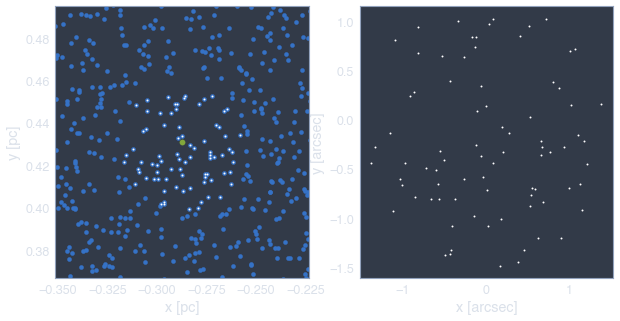

In [6]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.scatter(x,y, s=20)
ax1.scatter(testX0, testY0, s=3, color='white')
ax1.scatter(x0,y0)
ax1.set_xlabel('x [pc]')
ax1.set_ylabel('y [pc]')

# ax1.set_xlim(-2*rh,2*rh)
# ax1.set_ylim(-2*rh,2*rh)
mult = 2.
ax1.set_xlim(x0 - mult*dLim*seeingpc,x0 + mult*dLim*seeingpc)
ax1.set_ylim(y0 - mult*dLim*seeingpc,y0 + mult*dLim*seeingpc)

ax2.scatter(testXang0, testYang0, s=3, color='white')
ax2.set_xlabel('x [arcsec]')
ax2.set_ylabel('y [arcsec]')

## Try using my code to get fluxes for these stars

I will sort the stars by mass from the cluster center

In [7]:
sampler = getSingleStars(field['age[Myr]'].values[0], 
                             field['[Fe/H]'].values[0], 
                             100)
sampler.random_seed = 1111.
sampler.dist = dist/1000.
sampler.Nsing = len(testX0)
print(sampler.Nsing)
sampler.Initial_Single_Sample()
sampler.InitialSingles

80
initial single input: 1111.0 10345.238095238095 -1.56 80


,kstar_1,kstar_2,mass1_binary,mass2_binary,porb,ecc,metallicity,tphysf,mass0_1,mass0_2,...,tacc1,tacc2,epoch1,epoch2,tms1,tms2,bhspin1,bhspin2,tphys,binfrac
0,0.0,0.0,0.196195,0.0,1.000000e+10,0.339444,0.0001,10345.238095,0.196195,0.134106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.691092,0.0,1.000000e+10,0.756901,0.0001,10345.238095,0.691092,0.264792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.488405,0.0,1.000000e+10,0.419569,0.0001,10345.238095,0.488405,0.162931,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.404797,0.0,1.000000e+10,0.686036,0.0001,10345.238095,0.404797,0.129460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.175965,0.0,1.000000e+10,0.821656,0.0001,10345.238095,0.175965,0.174426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.0,1.0,1.425023,0.0,1.000000e+10,0.489286,0.0001,10345.238095,1.425023,0.774927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.247925,0.0,1.000000e+10,0.664326,0.0001,10345.238095,0.247925,0.132565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.565262,0.0,1.000000e+10,0.403845,0.0001,10345.238095,0.565262,0.146540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1.0,1.0,1.363079,0.0,1.000000e+10,0.483485,0.0001,10345.238095,1.363079,0.951425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,1.0,1.0,1.846397,0.0,1.000000e+10,0.921124,0.0001,10345.238095,1.846397,1.002150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
sampler.EvolveSingles()
sampler.SinglesEvolved

,tphys,kstar_1,mass0_1,mass_1,lumin_1,rad_1,teff_1,massc_1,radc_1,menv_1,...,B_0_2,SNkick_1,SNkick_2,Vsys_final,SNtheta_final,SN_1,SN_2,bin_state,merger_type,bin_num
0,10345.238095,0.0,0.196195,0.196195,0.009694,0.207440,3994.346818,0.000000,0.000000,9.809772e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,0
1,10345.238095,0.0,0.691092,0.691092,0.429303,0.669701,5734.822732,0.000000,0.000000,6.977534e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,1
2,10345.238095,0.0,0.488405,0.488405,0.069621,0.428760,4548.282044,0.000000,0.000000,1.593035e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,2
3,10345.238095,0.0,0.404797,0.404797,0.038313,0.357807,4288.255859,0.000000,0.000000,2.568950e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,3
4,10345.238095,0.0,0.175965,0.175965,0.007695,0.190270,3936.739454,0.000000,0.000000,8.798263e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,4
5,10345.238095,11.0,0.728106,0.728106,0.000005,0.011155,2591.154010,0.728106,0.011155,1.000000e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,5
6,10345.238095,0.0,0.247925,0.247925,0.015004,0.246769,4084.863875,0.000000,0.000000,1.239625e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,6
7,10345.238095,0.0,0.565262,0.565262,0.132347,0.507093,4910.822880,0.000000,0.000000,1.111665e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,7
8,10345.238095,11.0,0.709595,0.709595,0.000005,0.011379,2575.639639,0.709595,0.011379,1.000000e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,8
9,10345.238095,11.0,0.819121,0.819121,0.000004,0.010092,2605.784087,0.819121,0.010092,1.000000e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-001,9


In [9]:
#sort by mass and add the positions to the dataframe
singles = sampler.SinglesEvolved.sort_values(by='mass_1', ascending=False)
singles['x'] = testX0
singles['y'] = testY0
singles['z'] = testZ0
singles['r'] = (testX0**2. + testY0**2. + testZ0**2.)**0.5
singles['xang'] = testXang0
singles['yang'] = testYang0
singles

,tphys,kstar_1,mass0_1,mass_1,lumin_1,rad_1,teff_1,massc_1,radc_1,menv_1,...,SN_2,bin_state,merger_type,bin_num,x,y,z,r,xang,yang
46,10345.238095,13.0,11.957755,1.208609,2.130461e-10,0.000014,5920.031435,1.208609,0.000014,1.000000e-10,...,0.0,0,-001,46,-0.272601,0.413202,-0.014397,0.495232,0.688193,-0.833458
62,10345.238095,12.0,1.202680,1.202680,3.206908e-06,0.004928,3495.063629,1.202680,0.004928,1.000000e-10,...,0.0,0,-001,62,-0.271031,0.424040,0.124511,0.518431,0.761797,-0.325390
35,10345.238095,11.0,1.033300,1.033300,2.878220e-06,0.007681,2724.806181,1.033300,0.007681,1.000000e-10,...,0.0,0,-001,35,-0.299036,0.424350,0.011536,0.519258,-0.551029,-0.310869
45,10345.238095,11.0,1.003597,1.003597,3.093439e-06,0.008018,2715.546491,1.003597,0.008018,1.000000e-10,...,0.0,0,-001,45,-0.261404,0.421483,0.169279,0.524057,1.213090,-0.445265
75,10345.238095,1.0,0.853431,0.853431,4.948818e+00,1.512187,7032.216971,0.000000,0.000000,4.771240e-02,...,0.0,0,-001,75,-0.304696,0.451088,-0.061523,0.547818,-0.816355,0.942565
36,10345.238095,11.0,0.841174,0.841174,3.857677e-06,0.009841,2590.229287,0.841174,0.009841,1.000000e-10,...,0.0,0,-001,36,-0.302665,0.420606,0.181629,0.549094,-0.721168,-0.486378
9,10345.238095,11.0,0.819121,0.819121,4.155355e-06,0.010092,2605.784087,0.819121,0.010092,1.000000e-10,...,0.0,0,-001,9,-0.273015,0.425205,-0.222901,0.552287,0.668801,-0.270783
79,10345.238095,11.0,0.811102,0.811102,4.264758e-06,0.010184,2610.920818,0.811102,0.010184,1.000000e-10,...,0.0,0,-001,79,-0.289795,0.448922,-0.154946,0.556345,-0.117816,0.841026
78,10345.238095,11.0,0.803308,0.803308,4.419775e-06,0.010273,2622.828516,0.803308,0.010273,1.000000e-10,...,0.0,0,-001,78,-0.298058,0.422334,-0.233106,0.567047,-0.505172,-0.405392
24,10345.238095,11.0,0.797629,0.797629,4.570014e-06,0.010338,2636.460566,0.797629,0.010338,1.000000e-10,...,0.0,0,-001,24,-0.295291,0.413852,0.260360,0.571189,-0.375477,-0.803016


## Each of these stars now needs a flux

In [10]:
coord = SkyCoord(field['RA[hr]'].values[0], field['RA[hr]'].values[0], 
            unit=[units.hourangle, units.degree])
AV = extinction.get_AV_infinity(coord.ra, coord.dec, frame='icrs')
filters = ['u_', 'g_', 'r_', 'i_', 'z_', 'y_']       

In [11]:
singles

,tphys,kstar_1,mass0_1,mass_1,lumin_1,rad_1,teff_1,massc_1,radc_1,menv_1,...,SN_2,bin_state,merger_type,bin_num,x,y,z,r,xang,yang
46,10345.238095,13.0,11.957755,1.208609,2.130461e-10,0.000014,5920.031435,1.208609,0.000014,1.000000e-10,...,0.0,0,-001,46,-0.272601,0.413202,-0.014397,0.495232,0.688193,-0.833458
62,10345.238095,12.0,1.202680,1.202680,3.206908e-06,0.004928,3495.063629,1.202680,0.004928,1.000000e-10,...,0.0,0,-001,62,-0.271031,0.424040,0.124511,0.518431,0.761797,-0.325390
35,10345.238095,11.0,1.033300,1.033300,2.878220e-06,0.007681,2724.806181,1.033300,0.007681,1.000000e-10,...,0.0,0,-001,35,-0.299036,0.424350,0.011536,0.519258,-0.551029,-0.310869
45,10345.238095,11.0,1.003597,1.003597,3.093439e-06,0.008018,2715.546491,1.003597,0.008018,1.000000e-10,...,0.0,0,-001,45,-0.261404,0.421483,0.169279,0.524057,1.213090,-0.445265
75,10345.238095,1.0,0.853431,0.853431,4.948818e+00,1.512187,7032.216971,0.000000,0.000000,4.771240e-02,...,0.0,0,-001,75,-0.304696,0.451088,-0.061523,0.547818,-0.816355,0.942565
36,10345.238095,11.0,0.841174,0.841174,3.857677e-06,0.009841,2590.229287,0.841174,0.009841,1.000000e-10,...,0.0,0,-001,36,-0.302665,0.420606,0.181629,0.549094,-0.721168,-0.486378
9,10345.238095,11.0,0.819121,0.819121,4.155355e-06,0.010092,2605.784087,0.819121,0.010092,1.000000e-10,...,0.0,0,-001,9,-0.273015,0.425205,-0.222901,0.552287,0.668801,-0.270783
79,10345.238095,11.0,0.811102,0.811102,4.264758e-06,0.010184,2610.920818,0.811102,0.010184,1.000000e-10,...,0.0,0,-001,79,-0.289795,0.448922,-0.154946,0.556345,-0.117816,0.841026
78,10345.238095,11.0,0.803308,0.803308,4.419775e-06,0.010273,2622.828516,0.803308,0.010273,1.000000e-10,...,0.0,0,-001,78,-0.298058,0.422334,-0.233106,0.567047,-0.505172,-0.405392
24,10345.238095,11.0,0.797629,0.797629,4.570014e-06,0.010338,2636.460566,0.797629,0.010338,1.000000e-10,...,0.0,0,-001,24,-0.295291,0.413852,0.260360,0.571189,-0.375477,-0.803016


In [12]:
flux = {}
mag = {}
for f in filters:
    flux[f] = []
    mag[f] = []
    
for index, star in singles.iterrows():
    #sample a random star
    s = SingleStar()
    s.M_H = field['[Fe/H]'].values[0]

    s.RA = coord.ra.to(units.degree).value
    s.Dec = coord.dec.to(units.degree).value
    s.dist = field['dist[pc]'].values[0]/1000.
    s.AV = AV

    s.m = star['mass_1']
    s.R = star['rad_1']
    s.L = star['lumin_1']
    s.T = star['teff_1']
    s.initialize()
    #print(s.m, s.Fv, s.appMagMean)
    for f in filters:
        flux[f].append(s.Fv[f])
        mag[f].append(s.appMagMean[f])
        
for f in filters:
    singles['flux_'+f] = flux[f]    
    singles['mag_'+f] = mag[f]

## Now I want to plot these fluxes as Gaussians

In [13]:
def gauss2D(A, x1, mu1, s1, x2, mu2, s2):
    #http://mathworld.wolfram.com/GaussianFunction.html
    return A/(2.*np.pi*s1*s2)*np.exp(-((x1 - mu1)**2./(2.*s1**2.) + (x2 - mu2)**2./(2.*s2**2.)))
    
extent = int(np.ceil(seeing/2./LSSTpixel))
xvals = np.linspace(-extent*LSSTpixel, extent*LSSTpixel, 2*extent+1)
yvals = np.linspace(-extent*LSSTpixel, extent*LSSTpixel, 2*extent+1)
print(extent)
print(xvals)
# xvals = np.linspace(-dLim*seeing, dLim*seeing, numvals)
# yvals = np.linspace(-dLim*seeing, dLim*seeing, numvals)
zvals = np.zeros((len(xvals), len(yvals)))
xgrid, ygrid = np.meshgrid(xvals, yvals)
zgrid = {}
for f in filters:
    zgrid[f] = zvals
for i,x in enumerate(xvals):
    for j,y in enumerate(yvals):
        for index, star in singles.iterrows():
            for f in filters:
                amp = star['flux_'+f]
                zgrid[f][i,j] += gauss2D(amp, x, star['xang'], seeing, y, star['yang'], seeing)
        
                    

2
[-0.4 -0.2  0.   0.2  0.4]


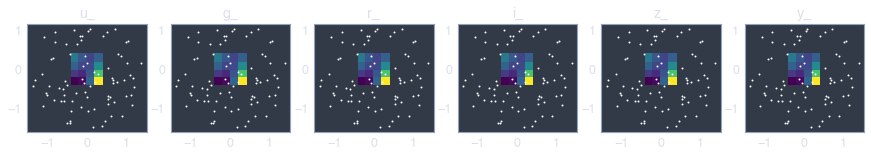

In [14]:
f,ax = plt.subplots(1,6, figsize=(15, 5))

for i,f in enumerate(filters):
    ax[i].pcolormesh(xgrid, ygrid, zgrid[f])#, norm=colors.LogNorm())
    ax[i].set_aspect(1)
    ax[i].set_title(f)
    ax[i].scatter(testXang0, testYang0, s=3, color='white')


### Integrate up the flux in this box and check the implied magnitude

In [15]:
#some redenning that will be supplied in the code
Ared = 0
dx = xvals[1] - xvals[0]
dy = yvals[1] - yvals[0]
dA = dx*dy
backgroundFlux = {}
backgroundMag = {}
for f in filters:
    backgroundFlux[f] = np.sum(zgrid[f]*dA)
    backgroundMag[f] = -2.5*np.log10(backgroundFlux[f]) + Ared
    
print(backgroundMag)
print(min(singles['mag_g_']))
print(s.Ared['g_'])
print(gauss2D(1., 0, 0, seeing, 0, 0, seeing))

{'u_': 16.259488165816823, 'g_': 16.259488165816823, 'r_': 16.259488165816823, 'i_': 16.259488165816823, 'z_': 16.259488165816823, 'y_': 16.259488165816823}
16.652473542006742
0.26678703073061466
0.6366197723675814


## Test my class for crowding

In [16]:
from crowding import crowding

%load_ext autoreload
%autoreload 2

In [19]:
coord = SkyCoord(field['RA[hr]'].values[0], field['RA[hr]'].values[0], 
            unit=[units.hourangle, units.degree])
AV = extinction.get_AV_infinity(coord.ra, coord.dec, frame='icrs')


crowd = crowding()
crowd.age = field['age[Myr]'].values[0]                       
crowd.FeH = field['[Fe/H]'].values[0]
crowd.dist = field['dist[pc]'].values[0]
crowd.Ncl = field['mass[Msun]'].values[0]/0.5 #assuming mean mass of 0.5 mSun
crowd.rPlummer = rPlummer
crowd.AV = AV
crowd.xBinary = x0
crowd.yBinary = y0
crowd.random_seed = 1111

crowd.getCrowding()

print(crowd.backgroundFlux)
print(crowd.backgroundMag)

initial single input: 1111 10345.238095238095 -1.56 80
{'u_': 3.134763155760341e-07, 'g_': 3.134763155760341e-07, 'r_': 3.134763155760341e-07, 'i_': 3.134763155760341e-07, 'z_': 3.134763155760341e-07, 'y_': 3.134763155760341e-07}
{'u_': 16.60916667971301, 'g_': 16.526275196547438, 'r_': 16.444018197384665, 'i_': 16.39407611923447, 'z_': 16.36375365507432, 'y_': 16.3463414486362}


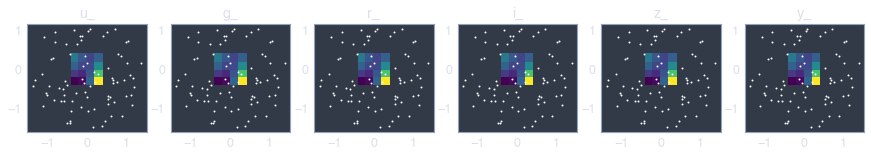

In [20]:
f,ax = plt.subplots(1,6, figsize=(15, 5))
for i,f in enumerate(filters):
    ax[i].pcolormesh(crowd.xgrid, crowd.ygrid, crowd.fluxgrid[f])#, norm=colors.LogNorm())
    ax[i].set_aspect(1)
    ax[i].set_title(f)
    ax[i].scatter(crowd.singles['xAng'], crowd.singles['yAng'], s=3, color='white')